In [ ]:
from flask import Flask, request
import numpy as np
import whisper
import zhconv
import torch
from wcpdtoolbox.imports import *

一直想要一个聊天机器人--也就是那种可以聊天的机器人(废话)

就是像siri那样可以听和读并且可以设置提醒,像chatgpt那样有能,并且最好接入qq什么的

## 需要的东西

首先,想想我需要什么来构筑这个...管道

1. 音频网络之类的接口
1. 语音转文字+文字转语音
2. 自然语言处理
3. 一大堆数据集

有了这些,大概就可以构筑这个模型了...至于形象,可以之后设置

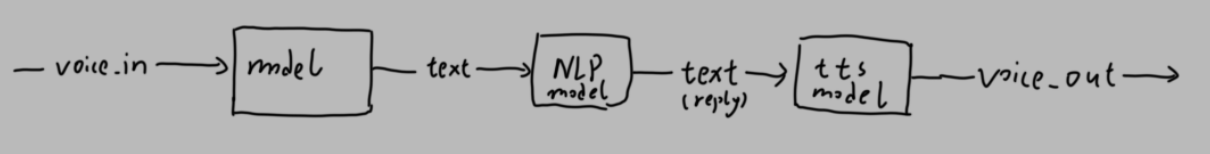

## 语音识别

步子不能迈太大:所以我准备先把语音识别处理了

一个后端与一个前端,但是前端我不是很熟...慢慢来吧

### 使用预训练模型

使用openai-whisper

In [ ]:
model = whisper.load_model("small", device="cuda")

#### 快速

In [ ]:
%%time
pred = model.transcribe("/ailearn/dataset/voice_dataset/audios/long0.wav")
zhconv.convert(pred["text"],  'zh-hans')

CPU times: user 2.72 s, sys: 0 ns, total: 2.72 s
Wall time: 2.47 s


'语音识别技术的应用包括语音波号,语音导航室内设备控制,语音文档检索,简单的听写数据输入等。语音识别技术与其他自然语言处理技术如机器翻译及语音课程技术相结合,可以构建出更加复杂的应用。语音识别技术作设举的领域包括信号处理,模式识别,概率论和信息论,发声机理和视觉听理,人工智能等等。'

效果挺好

#### 内部

加载音频

In [ ]:
audio = whisper.load_audio("/ailearn/dataset/voice_dataset/audios/long0.wav")
# audio = np.random.randn(1000).astype(np.float32)*10
audio = whisper.pad_or_trim(audio)
mel = whisper.log_mel_spectrogram(audio).to(model.device)

In [ ]:
audio.dtype

dtype('float32')

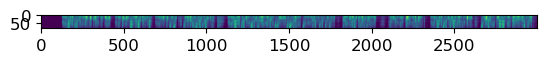

In [ ]:
plt.imshow(to_detach(mel))
plt.show()

decode the audio

In [ ]:
%%time
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.49 s


In [ ]:
result.text

'语音识别技术的应用包括语音波号,语音导航室内设备控制,语音文档检索,简单的听写数据输入等。语音识别技术与其他自然语言处理技术如机器翻译及语音课程技术相结合,可以构建出更加复杂的应用。'

*居然要整整1.5s来处理这东西...*

### 应用

应用需要制作一个可以使用get-post的东西,也就是后端
- 收:音频array
- 发:文本

In [ ]:
app = Flask(__name__)

In [ ]:
def pred_bytes(data):
    data = torch.frombuffer(data, dtype=torch.float32).float()
    data = whisper.pad_or_trim(data)
    mel = whisper.log_mel_spectrogram(data).to(model.device)
    plt.imshow(to_detach(mel))
    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    return result.text
    # nrint(pred)
    # return "qwq"

In [ ]:
def pred_bytes(data):
    data = torch.frombuffer(data, dtype=torch.int16).float()
    data = whisper.pad_or_trim(data)
    mel = whisper.log_mel_spectrogram(data).to(model.device)
    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    return result.text

In [ ]:
audio = whisper.load_audio("/ailearn/dataset/voice_dataset/audios/long0.wav")

'语音识别技术的应用包括语音波号,语音导航室内设备控制,语音文档检索,简单的听写数据输入等。语音识别技术与其他自然语言处理技术如机器翻译及语音课程技术相结合,可以构建出更加复杂的应用。'

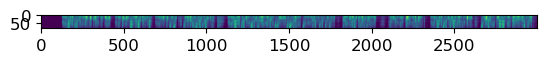

In [ ]:
pred_bytes(audio.tobytes())

In [ ]:
@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        text = pred_bytes(request.data)
        return text
    return "upload_frame"

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:43692
Press CTRL+C to quit
127.0.0.1 - - [13/Mar/2023 15:39:08] "POST / HTTP/1.1" 200 -


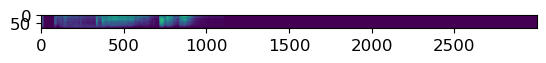

In [ ]:
app.run(port=43692)

# Flask测试2

更新

In [ ]:
model = whisper.load_model("medium").cuda()#.float()

In [ ]:
port = 43696
url = "http://localhost"

In [ ]:
gp = Queue()

一个数据传递类

使用队列进行阻塞,并使用numpy读取音频

In [ ]:
class P:
    def __init__(self, count: bytes):
        self.data = np.load(BytesIO(count)).astype("f4")/32768.0
        # q.put(self)
        self.q = Manager().Queue()
        self.need_to_pred = True
        
    def get(self)->str:
        try:
            text = self.q.get(timeout=15)
        except:
            self.need_to_pred = False
            text = "Oops, timeout"
        return text

循环识别

In [ ]:
def start_loop(q=gp):
    print("loop start")
    while True:
        p = q.get()
        if p.need_to_pred:
            data = p.data
            print("get data")
            text = model.transcribe(data)
            p.q.put(text)
        else:
            continue

服务器,使用`P`来吧数据传递到whisper

In [ ]:
app = Flask(__name__)
@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        cont = request.data
        p = P(cont)
        gp.put(p)
        print("put success")
        text = p.get()
        print("sent", text)
        return jsonify(text)
    #jsonify({"head":"cool,you up a file", "data":cont["file"]})
    return "send audio bytes 1d int16 16000rate"

调试时如果出错,可以把app给kill

In [ ]:
try: app_P.kill()
except: print("first_start")

In [ ]:
app_P = Process(target=app.run, kwargs=dict(port=port))
if __name__ == "__main__":
    app_P.start()
    start_loop()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:43696
Press CTRL+C to quit


loop start
put success
get data


MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_16.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


sent {'text': '我们的研究表明 与许多现有的ASR系统相比这些模型对口音 背景噪音 技术语言以及从多种语言到英语的零样本翻译者中表现出更高的入放性并且与音识别和翻译的准确性接近最先进的水平', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.48, 'text': '我们的研究表明 与许多现有的ASR系统相比', 'tokens': [50364, 15003, 1546, 23230, 242, 44704, 17571, 11100, 220, 940, 236, 7422, 116, 6392, 20204, 2412, 1546, 3160, 49, 25368, 10115, 253, 15106, 11706, 50588], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 1, 'seek': 0, 'start': 4.48, 'end': 7.68, 'text': '这些模型对口音 背景噪音 技术语言', 'tokens': [50588, 5562, 13824, 41908, 39823, 8713, 18144, 18034, 220, 46329, 50218, 21250, 103, 18034, 220, 32502, 1474, 107, 5233, 255, 12009, 50748], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 2, 'seek': 0, 'start': 7.68, 'end': 12.8, 'text': '以及从多种语言到英语的零样本翻译者中', 'tokens': [50748, 40282, 35630, 6392, 39810, 5233, 

127.0.0.1 - - [22/Mar/2023 12:42:35] "POST / HTTP/1.1" 200 -


put success
get data
sent {'text': '我们的研究表明 与许多现有的ASR系统相比这些模型对口音 背景噪音 技术语言以及从多种语言到英语的零样本翻译者中表现出更高的入放性并且与音识别和翻译的准确性接近最先进的水平', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.48, 'text': '我们的研究表明 与许多现有的ASR系统相比', 'tokens': [50364, 15003, 1546, 23230, 242, 44704, 17571, 11100, 220, 940, 236, 7422, 116, 6392, 20204, 2412, 1546, 3160, 49, 25368, 10115, 253, 15106, 11706, 50588], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 1, 'seek': 0, 'start': 4.48, 'end': 7.68, 'text': '这些模型对口音 背景噪音 技术语言', 'tokens': [50588, 5562, 13824, 41908, 39823, 8713, 18144, 18034, 220, 46329, 50218, 21250, 103, 18034, 220, 32502, 1474, 107, 5233, 255, 12009, 50748], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 2, 'seek': 0, 'start': 7.68, 'end': 12.8, 'text': '以及从多种语言到英语的零样本翻译者中', 'tokens': [50748, 40282, 35630

127.0.0.1 - - [22/Mar/2023 12:42:46] "POST / HTTP/1.1" 200 -


put success
get data
sent {'text': '我们的研究表明 与许多现有的ASR系统相比这些模型对口音 背景噪音 技术语言以及从多种语言到英语的零样本翻译者中表现出更高的入放性并且与音识别和翻译的准确性接近最先进的水平', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.48, 'text': '我们的研究表明 与许多现有的ASR系统相比', 'tokens': [50364, 15003, 1546, 23230, 242, 44704, 17571, 11100, 220, 940, 236, 7422, 116, 6392, 20204, 2412, 1546, 3160, 49, 25368, 10115, 253, 15106, 11706, 50588], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 1, 'seek': 0, 'start': 4.48, 'end': 7.68, 'text': '这些模型对口音 背景噪音 技术语言', 'tokens': [50588, 5562, 13824, 41908, 39823, 8713, 18144, 18034, 220, 46329, 50218, 21250, 103, 18034, 220, 32502, 1474, 107, 5233, 255, 12009, 50748], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 2, 'seek': 0, 'start': 7.68, 'end': 12.8, 'text': '以及从多种语言到英语的零样本翻译者中', 'tokens': [50748, 40282, 35630

127.0.0.1 - - [22/Mar/2023 12:45:07] "POST / HTTP/1.1" 200 -


put success
get data
sent {'text': '我们的研究表明 与许多现有的ASR系统相比这些模型对口音 背景噪音 技术语言以及从多种语言到英语的零样本翻译者中表现出更高的入放性并且与音识别和翻译的准确性接近最先进的水平', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 4.48, 'text': '我们的研究表明 与许多现有的ASR系统相比', 'tokens': [50364, 15003, 1546, 23230, 242, 44704, 17571, 11100, 220, 940, 236, 7422, 116, 6392, 20204, 2412, 1546, 3160, 49, 25368, 10115, 253, 15106, 11706, 50588], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 1, 'seek': 0, 'start': 4.48, 'end': 7.68, 'text': '这些模型对口音 背景噪音 技术语言', 'tokens': [50588, 5562, 13824, 41908, 39823, 8713, 18144, 18034, 220, 46329, 50218, 21250, 103, 18034, 220, 32502, 1474, 107, 5233, 255, 12009, 50748], 'temperature': 0.0, 'avg_logprob': -0.20650776012523755, 'compression_ratio': 1.1495327102803738, 'no_speech_prob': 0.01817532628774643}, {'id': 2, 'seek': 0, 'start': 7.68, 'end': 12.8, 'text': '以及从多种语言到英语的零样本翻译者中', 'tokens': [50748, 40282, 35630

127.0.0.1 - - [22/Mar/2023 12:45:16] "POST / HTTP/1.1" 200 -


KeyboardInterrupt: 

效果不能说特别好,可能需要微调...不过至少能用!